# **Homework 10 - Adversarial Attack**

- Simple baseline (acc <= 0.70)
  - Hints: FGSM
  - Expected running time: 1.5 mins on T4
- Medium baseline (acc <= 0.50)
  - Hints: Ensemble Attack + ensemble random few model + IFGSM
  - Expected running time: 5 mins on T4
- Strong baseline (acc <= 0.25)
  - Hints: Ensemble Attack + ensemble many models + MIFGSM
  - Expected running time: 5.5 mins on T4
- Boss baseline (acc <= 0.10)
  - Hints: Ensemble Attack + ensemble many models + DIM-MIFGSM
  - Expected running time: 8 mins on T4

## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [2]:
# set up environment
!pip install pytorchcv
!pip install imgaug

# download
# !gdown --id 1t2UFQXr1cr5qLMBK2oN2rY1NDypi9Nyw --output data.zip

# if the above link isn't available, try this one
!wget https://www.dropbox.com/s/lbpypqamqjpt2qz/data.zip

# unzip
!unzip ./data.zip

--2024-09-10 14:16:00--  https://www.dropbox.com/s/lbpypqamqjpt2qz/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/hp1asboajakihzavykt5v/data.zip?rlkey=v9x0j0udqonkwccz2jpe2tkkf [following]
--2024-09-10 14:16:01--  https://www.dropbox.com/scl/fi/hp1asboajakihzavykt5v/data.zip?rlkey=v9x0j0udqonkwccz2jpe2tkkf
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc68b88eca468e963b84b13cad62.dl.dropboxusercontent.com/cd/0/inline/CaUn8cBB19l34QLJXJYwnuMFO4aapbnqecCT2TOtpC4_X1R1CMRzZQUjBBwj3dy_vRPw7xoMY6mEjeQdDnmF1Vm6GwhVkSz1wg6h3mUVM_iIHpyy6ut57vxirTqznqg5RoD7UARonca8JE1mdfFVf7Fp/file# [following]
--2024-09-10 14:16:01--  https://uc68b88eca468e963b84b13cad62.dl.dropboxusercontent.com/cd/0/inline/CaUn8cBB19

In [3]:
!rm ./data.zip

In [4]:
import torch
import torch.nn as nn
from pytorchcv.model_provider import get_model as ptcv_get_model
import random
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

## Global Settings
#### **[NOTE]**: Don't change the settings here, or your generated image might not meet the constraint.
* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [5]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [6]:
root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [7]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))): # 所有类别子目录，并按字母顺序排序，每个子目录对应的index从0到9
            images = sorted(glob.glob(f'{class_dir}/*')) # 遍历class_dir中的所有的images，并按字母顺序排序
            self.images += images                        # 依次把十个类别中的images加到list中,在这个任务中，每个类别有20个images，有10个类别
            self.labels += ([i] * len(images))           # 把image对应的类别index加到labels中，eg: [0,0,0,0,0,0,0,0,0,0,1,1,1...9]
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images] # 将每个图像路径的相对路径添加到 self.names 列表中 [data_dir/class_dir/class1.png]
        self.transform = transform # 预处理
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images) # 返回数据集中的图像总数。

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [8]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

**FGSM (Fast Gradient Sign Method (FGSM)**   
$$
x^{adv}的目标是J(x^{real},y)最大\\
x^{adv} = x^{real} + ϵ ⋅ sign(\frac{\partial{J(x^{real},y)}}{\partial{x}0})$$     
**I-FGSM(Iterative Fast Gradient Sign Method)**      
$$
\begin{aligned}&\boldsymbol{x}_0^{adv}=\boldsymbol{x}^{real}\\&\mathrm{for~t=1~to~num\_iter:}\\&\boxed{\boldsymbol{x}_{t+1}^{adv}=\boldsymbol{x}_t^{adv}+\alpha\cdot\mathrm{sign}(\nabla_{\boldsymbol{x}}J(\boldsymbol{x}_t^{adv},y))}\\&\mathrm{clip~}\boldsymbol{x}_t^{adv}\end{aligned}   
$$
其中，$\alpha$是step size    
**MI-FGSM(Momentum Iterative Fast Gradient Sign Method)**     
使用momentum来稳定更新方向，并摆脱糟糕的局部最大值    
$$\begin{aligned}&\text{for t = 1 to num_iter:}\\&\boldsymbol{g}_{t+1}=\mu\cdot\boldsymbol{g}_t+\frac{\nabla_{\boldsymbol{x}}J(\boldsymbol{x}_t^{adv},y)}{\|\nabla_{\boldsymbol{x}}J(\boldsymbol{x}_t^{adv},y)\|_1},\quad\text{decay factor }\mu\\&\boxed{\boldsymbol{x}_{t+1}^{adv}=\boldsymbol{x}_t^{adv}+\alpha\cdot\operatorname{sign}(\boldsymbol{g}_{t+1}),}\\&\text{clip }\boldsymbol{x}_t^{adv}\end{aligned}$$    
其中$g$是momentum     
**M-DI2-FGSM(Diverse Input Momentum Iterative Fast Gradient Sign Method)**     
$$T(X_n^{adv};p)=\begin{cases}T(X_n^{adv})&\text{ with probability }p\\X_n^{adv}&\text{ with probability }1-p\end{cases}\\\text{e.g. DIM + MI-FGSM}\\g_{n+1}=\mu\cdot g_n+\frac{\nabla_XL(T(X_n^{adv};p),y^{\mathrm{true}};\theta)}{||\nabla_XL(T(X_n^{adv};p),y^{\mathrm{true}};\theta)||_1}$$     
这里的L可以用CrossEntropyLoss求解


In [79]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach()
    x_adv = x_adv + epsilon * grad.sign()
    return x_adv

# alpha and num_iter can be decided by yourself
alpha = 0.8/255/std

def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x.detach().clone()
    ################ TODO: Medium baseline #######################
    # write a loop with num_iter times
    for i in range(num_iter):
      # TODO: Each iteration, execute fgsm
      x_adv = fgsm(model, x_adv, y, loss_fn, epsilon=alpha)
      x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon) # 裁剪对抗样本

    return x_adv

"""
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    ################ TODO: Medium baseline #######################
    # write a loop with num_iter times
    for i in range(num_iter):
      # TODO: Each iteration, execute fgsm
      loss = loss_fn(model(x_adv), y) # calculate loss
      loss.backward()                 # calculate gradient
      grad = x_adv.grad.detach()      # get gradient
      x_adv = x_adv + alpha * grad.sign()
      x_adv = x_adv.detach()          # clean grad for next iteration
      x_adv.requires_grad = True      # x_adv need gradient

      # constrain the perturbation
      perturbation = x_adv - x
      perturbation = torch.where(perturbation > epsilon, epsilon, perturbation)
      perturbation = torch.where(perturbation < -epsilon, -epsilon, perturbation)
      x_adv = x + perturbation

    return x_adv
"""

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=50, decay=1.0):
    x_adv = x.detach().clone().to(device)
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)

    ################ TODO: Strong baseline ####################
    for i in range(num_iter):
      # TODO: Refer to the algorithm of MI-FGSM
      # Calculate the momentum and update
      x_adv.requires_grad = True
      loss = loss_fn(model(x_adv), y) # calculate loss
      loss.backward()
      grad = x_adv.grad.detach()      # get gradient
      momentum = decay * momentum + grad / torch.norm(grad, p=1) # update momentum

      # MI-FGSM
      x_adv = x_adv + alpha * momentum.sign()
      x_adv = x_adv.detach() # clean grad for next iteration
      x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon) # constrain the perturbation

    return x_adv

# boss baseline: DI-MIFGSM https://arxiv.org/pdf/1803.06978
import torch.nn.functional as F
import torchvision.transforms.functional as TF

def di_mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=50, decay=0.5, diversity_prob=0.5):
  x_adv = x.detach().clone().to(device) # x: (channel, height, width)
  # initialze momentum tensor
  momentum = torch.zeros_like(x).detach().to(device)

  for i in range(num_iter):
    # diverse input
    x_adv_diversity = random_transform(x_adv, diversity_prob)

    # calculate loss
    x_adv_diversity.requires_grad = True
    loss = loss_fn(model(x_adv_diversity), y) # calculate CrossEntropyLoss
    loss.backward()

    grad = x_adv_diversity.grad.detach()      # get gradient
    momentum = decay * momentum + grad / torch.norm(grad, p=1) # update momentum

    # MI-FGSM
    x_adv = x_adv + alpha * momentum.sign()
    x_adv = x_adv.detach() # clean grad for next iteration
    x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon) # constrain the perturbation

  return x_adv



def random_transform(x, diversity_prob=0.5, target_size=(32, 32)):
  # input对size 有要求
  # random resizing: resizes the input images to a random size
  if torch.rand(1) < diversity_prob:
    scale_factor = torch.rand(1).item() * 0.5 + 0.5  # scale_factor[0.5,1]
    new_size = (int(x.size(2) * scale_factor), int(x.size(3) * scale_factor)) # new height & new width
    x = F.interpolate(x, size=new_size, mode='bilinear', align_corners=False) # resize to new_size

  # random padding: pads zeros around the input images in a random manner)
  if torch.rand(1) < diversity_prob:
    pad_size = torch.randint(0, x.size(2) // 4, (1,)).item() # pad_size 0-0.25 height
    x = F.pad(x, (pad_size, pad_size, pad_size, pad_size), mode='constant', value=0) # Fill pad_size zeros on four boundaries to ensure height and width of the filled image are the same.

  # Ensure the output size matches the model's expected input size
  x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
  """
  if torch.rand(1) < diversity_prob:
    # 随机水平翻转
    x = torch.flip(x, dims=[3])
  if torch.rand(1) < diversity_prob:
    # 随机垂直翻转
    x = torch.flip(x, dims=[2])
  if torch.rand(1) < diversity_prob:
    # 随机旋转
    angle = torch.randint(0, 4, (1,)).item() * 90  # 0, 90, 180, 270 degrees
    x = TF.rotate(x, angle)
  """
  return x


## Utils -- Attack
* Recall
  * ToTensor() can be seen as a function where $T(x) = x/255$.
  * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
  * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
  * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
  * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
  * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [10]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv) # 输入对抗样本得到的预测输出
        loss = loss_fn(yp, y) # 对抗样本预测和真实样本的标签的loss
        train_acc += (yp.argmax(dim=1) == y).sum().item() # 当前batch的正确数目累加到train_acc
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # to numpy and round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        # 将各个批次的对抗样本 adv_ex 添加到 adv_examples 中
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex] # i=1: adv_examples = adv_ex; i>1: adv_examples和adv_ex按第一个维度拼接在一起
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset) # 返回整个数据集上生成的对抗样本，平均准确率和平均损失

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names): # adv_names对抗样本的名字和原样本的名字一样，只是路径不一样
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir) # 原始数据目录 data_dir 复制到目标目录 adv_dir
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # convert example from numpy to PILimage'im'; image pixel value should be unsigned int,unit 8:0-255
        im.save(os.path.join(adv_dir, name))           # 将图像 im 保存到目标目录 adv_dir 中，文件名为 name

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Other kinds of models are prohibited, and it will be considered to be cheating if you use them.

Note: Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [11]:
# This function is used to check whether you use models pretrained on cifar10 instead of other datasets
def model_checker(model_name):
  assert ('cifar10' in model_name) and ('cifar100' not in model_name), 'The model selected is not pretrained on cifar10!'

In [34]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model_name = 'resnet110_cifar10'
model_checker(model_name)

model = ptcv_get_model(model_name, pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn) # benign images acc & loss
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.95000, benign_loss = 0.22678


## Attack      

Esemble model

In [84]:
model_names = [
    'nin_cifar10',
    'resnet20_cifar10',
    'preresnet20_cifar10',
    'seresnet20_cifar10',
    'sepreresnet20_cifar10',
    'wrn16_10_cifar10',
    'wrn20_10_1bit_cifar10',
    'rir_cifar10',
    'diaresnet20_cifar10',
    'diapreresnet20_cifar10'
]

for model_name in model_names:
  model_checker(model_name)

ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()

ensembleNet(
  (models): ModuleList(
    (0): CIFARNIN(
      (features): Sequential(
        (stage1): Sequential(
          (unit1): NINConv(
            (conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
          (unit3): NINConv(
            (conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
        )
        (stage2): Sequential(
          (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (dropout2): Dropout(p=0.5, inplace=False)
          (unit1): NINConv(
            (conv): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 19

### FGSM

In [85]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(ensemble_model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.43000, fgsm_loss = 21.26936


In [14]:
# Package all the files in the fgsm directory into one compressed file, fgsm.tgz, and store it in the parent directory
%cd fgsm # Switch to the fgsm directory
!tar zcvf ../fgsm.tgz * # Package all files in the directory
%cd .. # Switch back to the parent directory

[Errno 2] No such file or directory: 'fgsm # Switch to the fgsm directory'
/content
data/
data/horse/
data/horse/horse14.png
data/horse/horse5.png
data/horse/horse3.png
data/horse/horse18.png
data/horse/horse13.png
data/horse/horse15.png
data/horse/horse12.png
data/horse/horse7.png
data/horse/horse16.png
data/horse/horse11.png
data/horse/horse8.png
data/horse/horse4.png
data/horse/horse19.png
data/horse/horse9.png
data/horse/horse17.png
data/horse/horse10.png
data/horse/horse6.png
data/horse/horse1.png
data/horse/horse2.png
data/horse/horse20.png
data/deer/
data/deer/deer11.png
data/deer/deer6.png
data/deer/deer16.png
data/deer/deer19.png
data/deer/deer13.png
data/deer/deer17.png
data/deer/deer4.png
data/deer/deer18.png
data/deer/deer20.png
data/deer/deer5.png
data/deer/deer2.png
data/deer/deer3.png
data/deer/deer1.png
data/deer/deer10.png
data/deer/deer15.png
data/deer/deer12.png
data/deer/deer8.png
data/deer/deer7.png
data/deer/deer14.png
data/deer/deer9.png
data/automobile/
data/aut

In [ ]:
from google.colab import files
files.download('fgsm.tgz') # 去掉tgz就ok了

### IFGSM     
medium

In [86]:
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

ifgsm_acc = 0.00000, ifgsm_loss = 119.13564


In [89]:
 # Package all the files in the fgsm directory into one compressed file, fgsm.tgz, and store it in the parent directory
%cd ifgsm # Switch to the fgsm directory
!tar zcvf ../ifgsm.tgz * # Package all files in the directory
%cd .. # Switch back to the parent directory

[Errno 2] No such file or directory: 'ifgsm # Switch to the fgsm directory'
/content
data/
data/horse/
data/horse/horse14.png
data/horse/horse5.png
data/horse/horse3.png
data/horse/horse18.png
data/horse/horse13.png
data/horse/horse15.png
data/horse/horse12.png
data/horse/horse7.png
data/horse/horse16.png
data/horse/horse11.png
data/horse/horse8.png
data/horse/horse4.png
data/horse/horse19.png
data/horse/horse9.png
data/horse/horse17.png
data/horse/horse10.png
data/horse/horse6.png
data/horse/horse1.png
data/horse/horse2.png
data/horse/horse20.png
data/deer/
data/deer/deer11.png
data/deer/deer6.png
data/deer/deer16.png
data/deer/deer19.png
data/deer/deer13.png
data/deer/deer17.png
data/deer/deer4.png
data/deer/deer18.png
data/deer/deer20.png
data/deer/deer5.png
data/deer/deer2.png
data/deer/deer3.png
data/deer/deer1.png
data/deer/deer10.png
data/deer/deer15.png
data/deer/deer12.png
data/deer/deer8.png
data/deer/deer7.png
data/deer/deer14.png
data/deer/deer9.png
data/automobile/
data/au

### MI-FGSM     
strong

In [87]:
adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, mifgsm, loss_fn)
print(f'mifgsm_acc = {mifgsm_acc:.5f}, mifgsm_loss = {mifgsm_loss:.5f}')

create_dir(root, 'mifgsm', adv_examples, adv_names)

mifgsm_acc = 0.13500, mifgsm_loss = 119.22219


In [80]:
# Package all the files in the fgsm directory into one compressed file, fgsm.tgz, and store it in the parent directory
%cd mifgsm # Switch to the fgsm directory
!tar zcvf ../mifgsm.tgz * # Package all files in the directory
%cd .. # Switch back to the parent directory

[Errno 2] No such file or directory: 'mifgsm # Switch to the fgsm directory'
/content
data/
data/horse/
data/horse/horse14.png
data/horse/horse5.png
data/horse/horse3.png
data/horse/horse18.png
data/horse/horse13.png
data/horse/horse15.png
data/horse/horse12.png
data/horse/horse7.png
data/horse/horse16.png
data/horse/horse11.png
data/horse/horse8.png
data/horse/horse4.png
data/horse/horse19.png
data/horse/horse9.png
data/horse/horse17.png
data/horse/horse10.png
data/horse/horse6.png
data/horse/horse1.png
data/horse/horse2.png
data/horse/horse20.png
data/deer/
data/deer/deer11.png
data/deer/deer6.png
data/deer/deer16.png
data/deer/deer19.png
data/deer/deer13.png
data/deer/deer17.png
data/deer/deer4.png
data/deer/deer18.png
data/deer/deer20.png
data/deer/deer5.png
data/deer/deer2.png
data/deer/deer3.png
data/deer/deer1.png
data/deer/deer10.png
data/deer/deer15.png
data/deer/deer12.png
data/deer/deer8.png
data/deer/deer7.png
data/deer/deer14.png
data/deer/deer9.png
data/automobile/
data/a

### M-DI2-FGSM

In [88]:
adv_examples, di_mifgsm_acc, di_mifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, di_mifgsm, loss_fn)
print(f'di_mifgsm_acc = {di_mifgsm_acc:.5f}, di_mifgsm_loss = {di_mifgsm_loss:.5f}')

create_dir(root, 'di_mifgsm', adv_examples, adv_names)

di_mifgsm_acc = 0.11000, di_mifgsm_loss = 89.88326


In [83]:
# Package all the files in the fgsm directory into one compressed file, fgsm.tgz, and store it in the parent directory
%cd di_mifgsm # Switch to the fgsm directory
!tar zcvf ../di_mifgsm.tgz * # Package all files in the directory
%cd .. # Switch back to the parent directory

[Errno 2] No such file or directory: 'di_mifgsm # Switch to the fgsm directory'
/content
data/
data/horse/
data/horse/horse14.png
data/horse/horse5.png
data/horse/horse3.png
data/horse/horse18.png
data/horse/horse13.png
data/horse/horse15.png
data/horse/horse12.png
data/horse/horse7.png
data/horse/horse16.png
data/horse/horse11.png
data/horse/horse8.png
data/horse/horse4.png
data/horse/horse19.png
data/horse/horse9.png
data/horse/horse17.png
data/horse/horse10.png
data/horse/horse6.png
data/horse/horse1.png
data/horse/horse2.png
data/horse/horse20.png
data/deer/
data/deer/deer11.png
data/deer/deer6.png
data/deer/deer16.png
data/deer/deer19.png
data/deer/deer13.png
data/deer/deer17.png
data/deer/deer4.png
data/deer/deer18.png
data/deer/deer20.png
data/deer/deer5.png
data/deer/deer2.png
data/deer/deer3.png
data/deer/deer1.png
data/deer/deer10.png
data/deer/deer15.png
data/deer/deer12.png
data/deer/deer8.png
data/deer/deer7.png
data/deer/deer14.png
data/deer/deer9.png
data/automobile/
dat

## Example of Ensemble Attack
* Ensemble multiple models as your proxy model to increase the black-box transferability ([paper](https://arxiv.org/abs/1611.02770))

In [19]:
################ BOSS BASELINE ######################

class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])

    def forward(self, x):
        #################### TODO: boss baseline ###################
        ensemble_logits = 0
        for i, m in enumerate(self.models):
          logits = m(x) # model output, m:: current model
          ensemble_logits += logits
        # TODO: sum up logits from multiple models
        return ensemble_logits

* Construct your ensemble model

In [29]:
model_names = [
    'nin_cifar10',
]

for model_name in model_names:
  model_checker(model_name)

ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()


ensembleNet(
  (models): ModuleList(
    (0): CIFARNIN(
      (features): Sequential(
        (stage1): Sequential(
          (unit1): NINConv(
            (conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
          (unit3): NINConv(
            (conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
        )
        (stage2): Sequential(
          (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (dropout2): Dropout(p=0.5, inplace=False)
          (unit1): NINConv(
            (conv): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 19

## Visualization

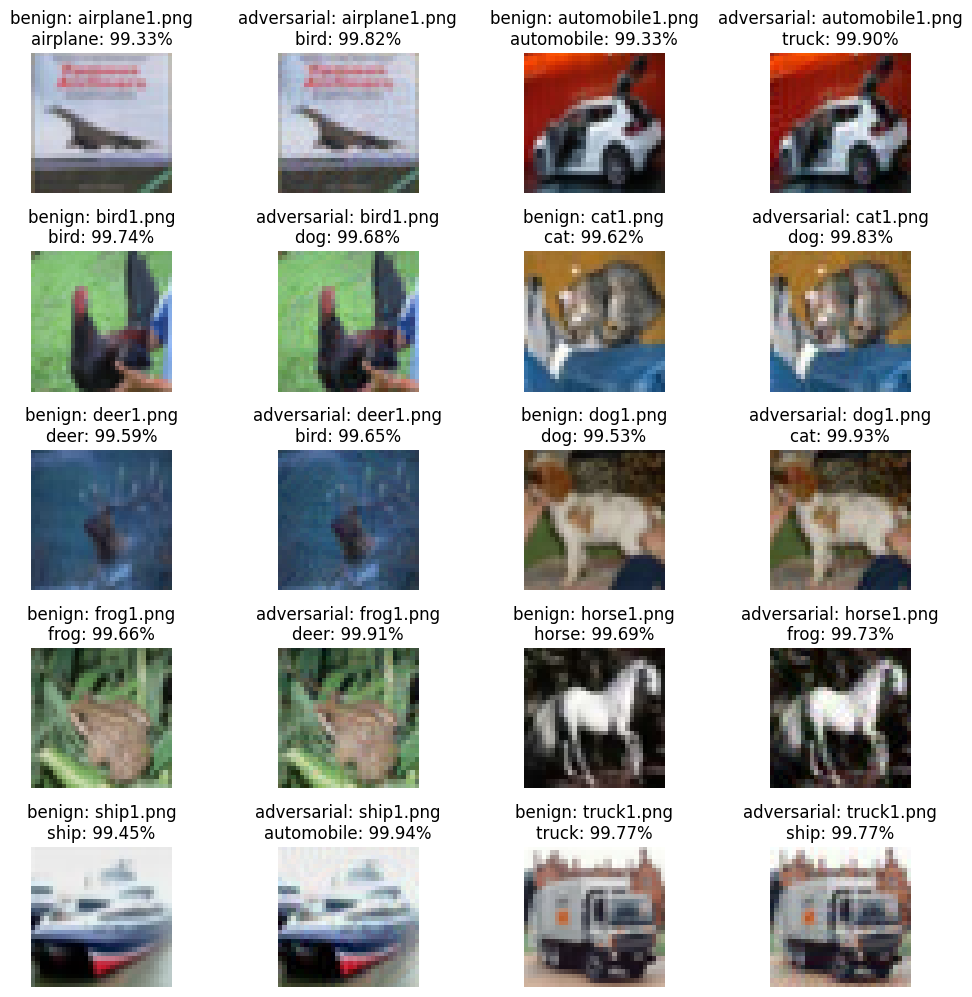

In [90]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ifgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Report Question
* Make sure you follow below setup: the source model is "resnet110_cifar10", applying the vanilla fgsm attack on `dog2.png`. You can find the perturbed image in `fgsm/dog2.png`.

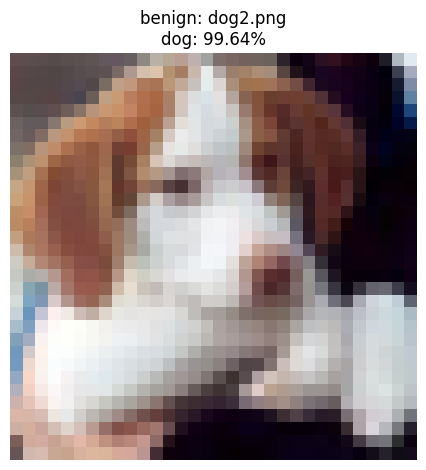

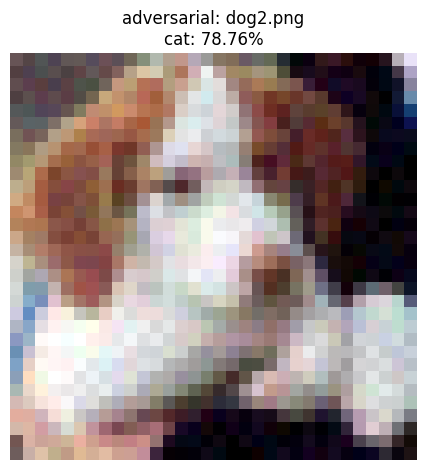

In [22]:
# original image
path = f'dog/dog2.png'
im = Image.open(f'./data/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'benign: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

# adversarial image
adv_im = Image.open(f'./fgsm/{path}')
logit = model(transform(adv_im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(adv_im))
plt.tight_layout()
plt.show()

## Passive Defense - JPEG compression
JPEG compression by imgaug package, compression rate set to 70

Reference: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html#imgaug.augmenters.arithmetic.JpegCompression

Note: If you haven't implemented the JPEG compression, this module will return an error. Don't worry about this.

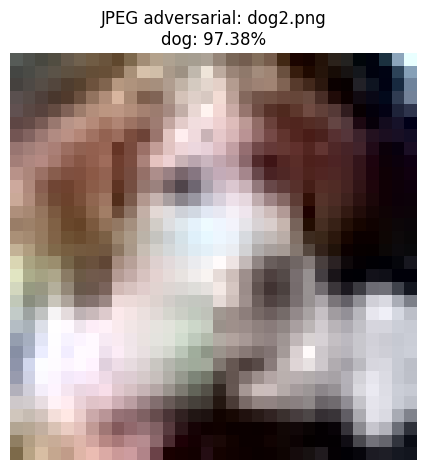

In [24]:
import imgaug.augmenters as iaa

# pre-process image
x = transforms.ToTensor()(adv_im)*255
x = x.permute(1, 2, 0).numpy()
x = x.astype(np.uint8)

# TODO: use "imgaug" package to perform JPEG compression (compression rate = 70)
compressed_x = iaa.JpegCompression(compression=70)(image=x)

logit = model(transform(compressed_x).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'JPEG adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')


plt.imshow(compressed_x)
plt.tight_layout()
plt.show()